In [1]:
# Melakukan impor libraries yang diperlukan untuk membangun model dan prediksi data.
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as MSE
import optuna
from optuna.samplers import TPESampler
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os
import random
import time
import datetime

In [2]:
# Mencatat waktu dimulainya keseluruhan program model dan prediksi data.
global_start_time = time.time()

In [3]:
# Menetapkan nilai seed untuk reproduksi model.
seed = 2021
def set_seed(seed = seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = str(seed)

set_seed()

In [4]:
# Menentukan indeks fold, kode penamaan program, banyak epoch, dan ukuran batch.
fold_index = 1
codename = '1_04_01_{}'.format(fold_index)
epochs = 128
batch_size = 64

In [5]:
# Menyusun data training.
df_train = pd.read_csv('../input/bdc-sd2021-train-tabular-data/train_gray.csv')
fake_train = pd.DataFrame(np.array(df_train).reshape((2305, 128, 128))[:, :, ::-1].reshape((2305, 128*128)))
fake_train.columns = df_train.columns
df_train = pd.concat([df_train, fake_train], ignore_index = True)
del fake_train

# Menyusun data testing.
df_test = pd.read_csv('../input/bdc-sd2021-test-tabular-data/test_gray.csv')

In [6]:
# Melakukan normalisasi pada data training.
scaler = MinMaxScaler(copy = False)
scaler.fit_transform(df_train.T)
df_train

,0,1,2,3,4,5,6,7,8,9,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,0.183857,0.139013,0.098655,0.116592,0.121076,0.103139,0.116592,0.094170,0.089686,0.076233,...,0.242152,0.089686,0.103139,0.121076,0.134529,0.156951,0.156951,0.156951,0.174888,0.152466
1,0.857868,0.857868,0.857868,0.857868,0.857868,0.857868,0.842640,0.827411,0.842640,0.827411,...,0.319797,0.294416,0.253807,0.208122,0.147208,0.116751,0.096447,0.065990,0.055838,0.040609
2,0.018182,0.013636,0.013636,0.018182,0.018182,0.018182,0.018182,0.018182,0.013636,0.018182,...,0.568182,0.559091,0.536364,0.518182,0.486364,0.436364,0.368182,0.254545,0.113636,0.045455
3,0.162500,0.162500,0.154167,0.154167,0.166667,0.187500,0.216667,0.254167,0.233333,0.183333,...,0.666667,0.675000,0.745833,0.887500,0.908333,0.900000,0.916667,0.945833,0.966667,0.966667
4,0.893023,0.860465,0.804651,0.879070,0.869767,0.637209,0.479070,0.269767,0.186047,0.186047,...,0.106977,0.032558,0.027907,0.018605,0.004651,0.000000,0.000000,0.004651,0.009302,0.018605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4605,0.090476,0.076190,0.095238,0.114286,0.090476,0.109524,0.076190,0.061905,0.052381,0.076190,...,0.157143,0.114286,0.133333,0.047619,0.061905,0.061905,0.052381,0.042857,0.042857,0.042857
4606,0.356828,0.370044,0.396476,0.409692,0.396476,0.422907,0.471366,0.515419,0.480176,0.436123,...,0.030837,0.035242,0.030837,0.026432,0.022026,0.017621,0.039648,0.026432,0.017621,0.035242
4607,0.306977,0.279070,0.339535,0.330233,0.320930,0.367442,0.367442,0.316279,0.283721,0.339535,...,0.060465,0.074419,0.065116,0.051163,0.051163,0.046512,0.083721,0.065116,0.055814,0.097674
4608,0.145000,0.240000,0.290000,0.295000,0.230000,0.170000,0.185000,0.200000,0.200000,0.230000,...,0.015000,0.015000,0.015000,0.015000,0.015000,0.015000,0.015000,0.010000,0.010000,0.010000


In [7]:
# Melakukan normalisasi pada data testing.
scaler.fit_transform(df_test.T)
df_test

,0,1,2,3,4,5,6,7,8,9,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,0.095238,0.100000,0.100000,0.095238,0.095238,0.100000,0.109524,0.114286,0.119048,0.104762,...,0.347619,0.361905,0.314286,0.400000,0.419048,0.261905,0.233333,0.300000,0.266667,0.257143
1,0.061983,0.061983,0.061983,0.061983,0.061983,0.061983,0.061983,0.061983,0.066116,0.066116,...,0.417355,0.322314,0.285124,0.471074,0.508264,0.475207,0.541322,0.644628,0.611570,0.512397
2,0.531120,0.493776,0.485477,0.427386,0.402490,0.356846,0.340249,0.356846,0.336100,0.340249,...,0.190871,0.112033,0.062241,0.058091,0.074689,0.066390,0.058091,0.053942,0.045643,0.053942
3,0.796703,0.796703,0.791209,0.791209,0.796703,0.818681,0.818681,0.785714,0.763736,0.763736,...,0.961538,0.950549,0.950549,0.945055,0.939560,0.928571,0.923077,0.917582,0.906593,0.879121
4,0.222222,0.232804,0.232804,0.248677,0.253968,0.259259,0.248677,0.243386,0.243386,0.243386,...,0.619048,0.613757,0.608466,0.608466,0.613757,0.592593,0.566138,0.502646,0.470899,0.449735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,0.828571,0.844898,0.804082,0.824490,0.918367,0.963265,0.987755,0.959184,0.873469,0.722449,...,0.857143,0.848980,0.828571,0.832653,0.840816,0.840816,0.816327,0.820408,0.783673,0.767347
986,0.048780,0.065041,0.077236,0.105691,0.117886,0.121951,0.126016,0.069106,0.060976,0.052846,...,0.186992,0.207317,0.223577,0.239837,0.260163,0.284553,0.304878,0.321138,0.337398,0.357724
987,0.056872,0.056872,0.061611,0.061611,0.071090,0.056872,0.037915,0.023697,0.009479,0.018957,...,0.900474,0.890995,0.895735,0.900474,0.895735,0.895735,0.890995,0.890995,0.890995,0.890995
988,0.109244,0.155462,0.168067,0.121849,0.113445,0.088235,0.079832,0.084034,0.079832,0.067227,...,0.525210,0.281513,0.050420,0.033613,0.037815,0.033613,0.033613,0.042017,0.042017,0.042017


In [8]:
# Memunculkan target prediksi.
target_0 = pd.read_csv('../input/bdc-sd2021-data-tambahan/train_target_and_fold.csv')[['usia', 'fold']]
target_1 = pd.concat([target_0 for iteration in range(2)], ignore_index = True)
target_1

,usia,fold
0,27,3
1,27,3
2,27,3
3,24,0
4,24,0
...,...,...
4605,23,4
4606,23,4
4607,27,4
4608,27,4


In [9]:
# Melakukan penambahan data training yang berkaitan dengan posisi relatif fitur pada wajah.
df_train_1 = pd.read_csv('../input/bdc-sd2021-data-tambahan/train_facial_relative.csv')
fake_train_1 = df_train_1.copy()
fake_train_1['x_le'] = 1 - df_train_1['x_re']
fake_train_1['x_re'] = 1 - df_train_1['x_le']
fake_train_1['x_n'] = 1 - df_train_1['x_n']
fake_train_1['x_ml'] = 1 - df_train_1['x_mr']
fake_train_1['x_mr'] = 1 - df_train_1['x_ml']
fake_train_1[['sym_le_n', 'adj_le_n', 'sym_re_n', 'adj_re_n']] = df_train_1[['sym_re_n', 'adj_re_n', 'sym_le_n', 'adj_le_n']]
fake_train_1[['sym_le_ml', 'adj_le_ml', 'sym_re_mr', 'adj_re_mr']] = df_train_1[['sym_re_mr', 'adj_re_mr', 'sym_le_ml', 'adj_le_ml']]
fake_train_1[['sym_le_mr', 'adj_le_mr', 'sym_re_ml', 'adj_re_ml']] = df_train_1[['sym_re_ml', 'adj_re_ml', 'sym_le_mr', 'adj_le_mr']]
fake_train_1[['sym_n_ml', 'adj_n_ml', 'sym_n_mr', 'adj_n_mr']] = df_train_1[['sym_n_mr', 'adj_n_mr', 'sym_n_ml', 'adj_n_ml']]

df_train_1 = pd.concat([df_train_1, fake_train_1], ignore_index = True)
del fake_train_1

df_train_1

,x_le,y_le,x_re,y_re,x_n,y_n,x_ml,y_ml,x_mr,y_mr,...,adj_n_ml,sym_le_mr,adj_le_mr,sym_re_mr,adj_re_mr,sym_n_mr,adj_n_mr,sym_ml_mr,adj_ml_mr,abs_angle
0,0.204545,0.390411,0.698052,0.392694,0.405844,0.618721,0.194805,0.712329,0.733766,0.705479,...,0.249515,0.615908,0.693416,0.314818,0.446237,0.339205,0.350364,0.539005,0.539049,0.061566
1,0.179724,0.397351,0.589862,0.403974,0.290323,0.619205,0.202765,0.725166,0.635945,0.728477,...,0.171500,0.563722,0.648461,0.327759,0.453958,0.362484,0.377599,0.433192,0.433204,0.134023
2,0.195946,0.404878,0.662162,0.404878,0.378378,0.614634,0.202703,0.731707,0.682432,0.731707,...,0.239078,0.586077,0.664537,0.327457,0.453156,0.325814,0.344595,0.479730,0.479730,0.174672
3,0.266055,0.373239,0.715596,0.373239,0.440367,0.549296,0.238532,0.690141,0.724771,0.704225,...,0.272772,0.565660,0.629561,0.331113,0.431290,0.323865,0.348745,0.486442,0.486585,0.121842
4,0.244565,0.389764,0.695652,0.393701,0.413043,0.578740,0.217391,0.696850,0.706522,0.712598,...,0.254682,0.563583,0.641880,0.319083,0.440352,0.322564,0.346806,0.489384,0.489613,0.012195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4605,0.362934,0.401146,0.803089,0.383954,0.660232,0.616046,0.389961,0.759312,0.737452,0.753582,...,0.327708,0.530242,0.629355,0.364131,0.487068,0.162752,0.207921,0.347538,0.347576,0.540420
4606,0.232323,0.386256,0.744108,0.398104,0.515152,0.649289,0.313131,0.772512,0.717172,0.779621,...,0.274054,0.612584,0.719783,0.387194,0.549482,0.236635,0.267332,0.404103,0.404167,0.552494
4607,0.274869,0.400372,0.759162,0.396648,0.523560,0.616387,0.324607,0.780261,0.685864,0.780261,...,0.304386,0.562206,0.678031,0.386895,0.539038,0.230645,0.281800,0.361257,0.361257,0.162489
4608,0.323887,0.405836,0.801619,0.413793,0.668016,0.631300,0.425101,0.801061,0.785425,0.814324,...,0.370196,0.602490,0.749939,0.395557,0.603456,0.206407,0.284469,0.360568,0.360892,0.456213


In [10]:
# Melakukan penambahan data testing yang berkaitan dengan posisi relatif fitur pada wajah.
df_test_1 = pd.read_csv('../input/bdc-sd2021-data-tambahan/test_facial_relative.csv')
df_test_1

,x_le,y_le,x_re,y_re,x_n,y_n,x_ml,y_ml,x_mr,y_mr,...,adj_n_ml,sym_le_mr,adj_le_mr,sym_re_mr,adj_re_mr,sym_n_mr,adj_n_mr,sym_ml_mr,adj_ml_mr,abs_angle
0,0.291209,0.333333,0.758242,0.338028,0.521978,0.516432,0.296703,0.732394,0.730769,0.737089,...,0.338570,0.596852,0.645365,0.400006,0.467840,0.303782,0.332088,0.434091,0.434101,0.070471
1,0.281690,0.405128,0.753521,0.394872,0.549296,0.625641,0.260563,0.723077,0.746479,0.707692,...,0.318229,0.554593,0.623428,0.312900,0.429635,0.213573,0.227106,0.486159,0.486375,0.029403
2,0.214533,0.403023,0.660900,0.397985,0.366782,0.612091,0.235294,0.727960,0.692042,0.722922,...,0.206456,0.574761,0.648943,0.326426,0.447452,0.343624,0.359129,0.456775,0.456800,0.022553
3,0.365517,0.391753,0.779310,0.402062,0.648276,0.597938,0.393103,0.773196,0.758621,0.757732,...,0.346547,0.537095,0.627927,0.356271,0.476312,0.194191,0.240590,0.365844,0.366102,0.064427
4,0.265625,0.381323,0.734375,0.369650,0.500000,0.603113,0.296875,0.747082,0.718750,0.735409,...,0.279993,0.575064,0.655712,0.366092,0.489833,0.255644,0.281443,0.422036,0.422164,0.044914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,0.356364,0.398892,0.821818,0.398892,0.650909,0.617729,0.374545,0.739612,0.785455,0.736842,...,0.319338,0.546195,0.617197,0.339901,0.445124,0.179696,0.206282,0.410918,0.410925,0.124355
986,0.274725,0.380952,0.758242,0.373016,0.582418,0.563492,0.362637,0.777778,0.747253,0.753968,...,0.369237,0.602016,0.700027,0.381111,0.527587,0.251896,0.311010,0.385352,0.386026,0.047583
987,0.289855,0.373737,0.753623,0.383838,0.521739,0.585859,0.275362,0.737374,0.724638,0.747475,...,0.328573,0.573337,0.690348,0.364790,0.522544,0.259399,0.308120,0.449389,0.449509,0.031240
988,0.142857,0.338403,0.614286,0.338403,0.319048,0.593156,0.200000,0.779468,0.557143,0.779468,...,0.261948,0.605120,0.690476,0.444751,0.555329,0.302327,0.333367,0.357143,0.357143,0.020199


In [11]:
# Menyusun indeks untuk data training dan melakukan shuffle.
train_index = list(target_1[target_1['fold'] != fold_index].index)
random.seed(seed)
random.shuffle(train_index)

# Menyusun indeks untuk data validasi.
valid_index = list(target_0[target_0['fold'] == fold_index].index)

# Memisahkan data validasi dari data training, serta menginisiasi data testing.
X_train = df_train.iloc[train_index]
X_valid = df_train.iloc[valid_index]
X_test = df_test.copy()

X_train_1 = df_train_1.iloc[train_index]
X_valid_1 = df_train_1.iloc[valid_index]
X_test_1 = df_test_1.copy()

# Melakukan reduksi dimensi dengan menggunakan PCA.
pca = PCA(0.95)
X_train = pd.DataFrame(pca.fit_transform(X_train))
X_valid = pd.DataFrame(pca.transform(X_valid))
X_test = pd.DataFrame(pca.transform(X_test))

pca = PCA(0.95)
X_train_1 = pd.DataFrame(pca.fit_transform(X_train_1))
X_valid_1 = pd.DataFrame(pca.transform(X_valid_1))
X_test_1 = pd.DataFrame(pca.transform(X_test_1))

# Menggabungkan informasi pada data training, validasi, dan testing.
X_train = pd.concat([X_train, X_train_1], axis = 1, ignore_index = True)
X_valid = pd.concat([X_valid, X_valid_1], axis = 1, ignore_index = True)
X_test = pd.concat([X_test, X_test_1], axis = 1, ignore_index = True)
del X_train_1, X_valid_1, X_test_1

# Mengubah ukuran data agar sesuai dengan input yang diharapkan oleh model.
X_train = X_train.values.reshape(-1, X_train.shape[1], 1).astype('float64')
X_valid = X_valid.values.reshape(-1, X_valid.shape[1], 1).astype('float64')
X_test = X_test.values.reshape(-1, X_test.shape[1], 1).astype('float64')

# Memisahkan target validasi dari target training.
y_train = target_1.iloc[train_index, 0].astype('int64')
y_valid = target_0.iloc[valid_index, 0].astype('int64')

# Membuang informasi yang sudah tidak diperlukan lagi.
del df_train, df_test, df_train_1, df_test_1, pca, target_0, target_1, train_index, valid_index

In [12]:
# Mendefinisikan fungsi untuk mencari parameter terbaik dengan nilai error terkecil.
def create_model(trial):
    n_layers = trial.suggest_int('n_layers', 2, 5)
    weight_decay = trial.suggest_float('weight_decay', 1e-10, 1e-3, log = True)
    dropout = trial.suggest_float('dropout', 0.2, 0.5, log = True)
    model = Sequential()
    for i in range(n_layers-1):
        num_hidden = trial.suggest_int('n_units_l{}'.format(i), 32, 256, log = True)
        if i:
            model.add(Dense(num_hidden,
                            activation = 'relu',
                            kernel_regularizer = regularizers.l2(weight_decay)))
            model.add(Dropout(dropout))
        else:
            model.add(Dense(num_hidden,
                            activation = 'relu',
                            kernel_regularizer = regularizers.l2(weight_decay),
                            input_shape = (X_train.shape[1], 1)))
    model.add(Flatten())
    num_hidden = trial.suggest_int('n_units_l{}'.format(n_layers-1), 32, 256, log = True)
    model.add(Dense(num_hidden,
                    activation = 'relu',
                    kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(Dense(1,
                    activation = 'linear',
                    kernel_regularizer = regularizers.l2(weight_decay)))
    return model

def create_optimizer(trial):
    kwargs = {}
    optimizer_options = ['RMSprop', 'Adam', 'SGD']
    optimizer_selected = trial.suggest_categorical('optimizer', optimizer_options)
    if optimizer_selected == 'RMSprop':
        kwargs['learning_rate'] = trial.suggest_float(
            'rmsprop_learning_rate', 1e-5, 1e-1, log=True)
        kwargs['decay'] = trial.suggest_float('rmsprop_decay', 0.85, 0.99)
        kwargs['momentum'] = trial.suggest_float('rmsprop_momentum', 1e-5, 1e-1, log = True)
    elif optimizer_selected == 'Adam':
        kwargs['learning_rate'] = trial.suggest_float('adam_learning_rate', 1e-5, 1e-1, log = True)
    elif optimizer_selected == 'SGD':
        kwargs['learning_rate'] = trial.suggest_float(
            'sgd_opt_learning_rate', 1e-5, 1e-1, log=True)
        kwargs['momentum'] = trial.suggest_float('sgd_opt_momentum', 1e-5, 1e-1, log = True)
    
    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer

def objective(trial):
    model = create_model(trial)
    optimizer = create_optimizer(trial)
    model.compile(optimizer = optimizer,
                  loss = 'mean_squared_error',
                  metrics = ['mse'])
    set_seed()
    history = model.fit(X_train, y_train,
                        epochs = 3,
                        validation_data = (X_valid, y_valid),
                        verbose = 2,
                        steps_per_epoch = X_train.shape[0] // batch_size)
    y_valid_pred = model.predict(X_valid)
    try:
        mse = MSE(y_valid, y_valid_pred)
    except ValueError:
        mse = 1e+32
    return mse

In [13]:
# Mencari hyperparameters terbaik.
try:
    study = optuna.create_study(sampler = TPESampler(seed = seed), direction = 'minimize')
    study.optimize(objective, n_trials = 50)
except ValueError:
    pass

[I 2021-11-04 11:15:34,495] A new study created in memory with name: no-name-37069104-b2e2-4037-ad76-f67676812d2a

User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIN

Epoch 1/3
57/57 - 6s - loss: 634.8336 - mse: 634.8301 - val_loss: 423.8717 - val_mse: 423.8681
Epoch 2/3
57/57 - 4s - loss: 125.6765 - mse: 125.6729 - val_loss: 36.1906 - val_mse: 36.1870
Epoch 3/3
57/57 - 4s - loss: 40.1108 - mse: 40.1071 - val_loss: 34.7381 - val_mse: 34.7345


[I 2021-11-04 11:15:49,618] Trial 0 finished with value: 34.73448750497162 and parameters: {'n_layers': 4, 'weight_decay': 1.3601459990500093e-05, 'dropout': 0.22715517141780636, 'n_units_l0': 61, 'n_units_l1': 255, 'n_units_l2': 41, 'n_units_l3': 46, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 2.4410551066709827e-05, 'sgd_opt_momentum': 1.7150829926878746e-05}. Best is trial 0 with value: 34.73448750497162.


Epoch 1/3
57/57 - 10s - loss: 254.3599 - mse: 254.3587 - val_loss: 35.4346 - val_mse: 35.4334
Epoch 2/3
57/57 - 9s - loss: 36.6444 - mse: 36.6433 - val_loss: 32.9135 - val_mse: 32.9123
Epoch 3/3
57/57 - 9s - loss: 34.1625 - mse: 34.1613 - val_loss: 31.4375 - val_mse: 31.4363


[I 2021-11-04 11:16:17,838] Trial 1 finished with value: 31.43630854105587 and parameters: {'n_layers': 5, 'weight_decay': 2.069674778352553e-06, 'dropout': 0.2165227444547113, 'n_units_l0': 102, 'n_units_l1': 115, 'n_units_l2': 238, 'n_units_l3': 105, 'n_units_l4': 69, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 6.0309245793449296e-05, 'sgd_opt_momentum': 0.0021618027516387694}. Best is trial 1 with value: 31.43630854105587.


Epoch 1/3
57/57 - 3s - loss: 76.3753 - mse: 76.3751 - val_loss: 34.1831 - val_mse: 34.1829
Epoch 2/3
57/57 - 2s - loss: 31.7772 - mse: 31.7770 - val_loss: 29.9077 - val_mse: 29.9075
Epoch 3/3
57/57 - 2s - loss: 27.2061 - mse: 27.2059 - val_loss: 38.6936 - val_mse: 38.6933


[I 2021-11-04 11:16:25,787] Trial 2 finished with value: 38.693349207880566 and parameters: {'n_layers': 3, 'weight_decay': 4.2140608469491625e-07, 'dropout': 0.425181023662834, 'n_units_l0': 146, 'n_units_l1': 36, 'n_units_l2': 129, 'optimizer': 'Adam', 'adam_learning_rate': 0.0029509089780652155}. Best is trial 1 with value: 31.43630854105587.


Epoch 1/3
57/57 - 7s - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 2/3
57/57 - 6s - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 3/3
57/57 - 6s - loss: nan - mse: nan - val_loss: nan - val_mse: nan


[I 2021-11-04 11:16:45,461] Trial 3 finished with value: 1e+32 and parameters: {'n_layers': 4, 'weight_decay': 1.280797128821542e-08, 'dropout': 0.4445600696908863, 'n_units_l0': 108, 'n_units_l1': 247, 'n_units_l2': 80, 'n_units_l3': 41, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.006855869932485577, 'sgd_opt_momentum': 0.03652763447965056}. Best is trial 1 with value: 31.43630854105587.


Epoch 1/3
57/57 - 4s - loss: 156.8244 - mse: 156.8236 - val_loss: 34.4153 - val_mse: 34.4145
Epoch 2/3
57/57 - 3s - loss: 34.9324 - mse: 34.9316 - val_loss: 35.2198 - val_mse: 35.2191
Epoch 3/3
57/57 - 3s - loss: 32.6407 - mse: 32.6399 - val_loss: 33.5615 - val_mse: 33.5607


[I 2021-11-04 11:16:55,521] Trial 4 finished with value: 33.56075167510972 and parameters: {'n_layers': 4, 'weight_decay': 2.869521426120942e-06, 'dropout': 0.2736582989224417, 'n_units_l0': 177, 'n_units_l1': 60, 'n_units_l2': 60, 'n_units_l3': 48, 'optimizer': 'Adam', 'adam_learning_rate': 0.0003587550277569686}. Best is trial 1 with value: 31.43630854105587.


Epoch 1/3
57/57 - 5s - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 2/3
57/57 - 4s - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 3/3
57/57 - 4s - loss: nan - mse: nan - val_loss: nan - val_mse: nan


[I 2021-11-04 11:17:09,987] Trial 5 finished with value: 1e+32 and parameters: {'n_layers': 4, 'weight_decay': 8.671491605192508e-05, 'dropout': 0.2120474687506201, 'n_units_l0': 75, 'n_units_l1': 63, 'n_units_l2': 143, 'n_units_l3': 85, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.012820573397259222, 'sgd_opt_momentum': 0.01219735525440408}. Best is trial 1 with value: 31.43630854105587.


Epoch 1/3
57/57 - 2s - loss: 96.6569 - mse: 96.6566 - val_loss: 51.8062 - val_mse: 51.8060
Epoch 2/3
57/57 - 1s - loss: 47.5060 - mse: 47.5058 - val_loss: 44.3367 - val_mse: 44.3365
Epoch 3/3
57/57 - 1s - loss: 42.9320 - mse: 42.9318 - val_loss: 42.8384 - val_mse: 42.8382


[I 2021-11-04 11:17:13,539] Trial 6 finished with value: 42.83820703611039 and parameters: {'n_layers': 2, 'weight_decay': 1.4490033299339797e-06, 'dropout': 0.4134236878013778, 'n_units_l0': 56, 'n_units_l1': 69, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.0004666904757351211, 'rmsprop_decay': 0.894925822839254, 'rmsprop_momentum': 0.000308450498248823}. Best is trial 1 with value: 31.43630854105587.


Epoch 1/3
57/57 - 4s - loss: 51693.7031 - mse: 51693.6797 - val_loss: 95.0701 - val_mse: 95.0516
Epoch 2/3
57/57 - 3s - loss: 114.4079 - mse: 114.3893 - val_loss: 68.6590 - val_mse: 68.6405
Epoch 3/3
57/57 - 3s - loss: 87.6211 - mse: 87.6026 - val_loss: 51.5808 - val_mse: 51.5623


[I 2021-11-04 11:17:24,899] Trial 7 finished with value: 51.562279684989946 and parameters: {'n_layers': 3, 'weight_decay': 5.713328696681321e-06, 'dropout': 0.3407865362809055, 'n_units_l0': 241, 'n_units_l1': 75, 'n_units_l2': 63, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.019638650422524002, 'rmsprop_decay': 0.9279674621367233, 'rmsprop_momentum': 0.007481765717358807}. Best is trial 1 with value: 31.43630854105587.


Epoch 1/3
57/57 - 7s - loss: 592376.3750 - mse: 592376.3750 - val_loss: 152.1273 - val_mse: 152.1265
Epoch 2/3
57/57 - 5s - loss: 89.9662 - mse: 89.9654 - val_loss: 496.6796 - val_mse: 496.6787
Epoch 3/3
57/57 - 5s - loss: 49.3858 - mse: 49.3851 - val_loss: 457.9046 - val_mse: 457.9038


[I 2021-11-04 11:17:41,509] Trial 8 finished with value: 457.90383606235645 and parameters: {'n_layers': 5, 'weight_decay': 2.9653117862224153e-07, 'dropout': 0.3197493177048565, 'n_units_l0': 123, 'n_units_l1': 65, 'n_units_l2': 116, 'n_units_l3': 83, 'n_units_l4': 41, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.019054962911205356, 'rmsprop_decay': 0.874518227528278, 'rmsprop_momentum': 8.371297680962848e-05}. Best is trial 1 with value: 31.43630854105587.


Epoch 1/3
57/57 - 10s - loss: 3393.5132 - mse: 3393.4929 - val_loss: 46.4741 - val_mse: 46.4526
Epoch 2/3
57/57 - 9s - loss: 46.7461 - mse: 46.7246 - val_loss: 52.9697 - val_mse: 52.9483
Epoch 3/3
57/57 - 9s - loss: 43.0072 - mse: 42.9857 - val_loss: 48.0517 - val_mse: 48.0303


[I 2021-11-04 11:18:10,064] Trial 9 finished with value: 48.03028401045839 and parameters: {'n_layers': 4, 'weight_decay': 1.0556840099451229e-05, 'dropout': 0.22909938508654398, 'n_units_l0': 72, 'n_units_l1': 170, 'n_units_l2': 172, 'n_units_l3': 167, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.005553572385099785, 'rmsprop_decay': 0.9526963318618572, 'rmsprop_momentum': 3.908613352528237e-05}. Best is trial 1 with value: 31.43630854105587.


Epoch 1/3
57/57 - 15s - loss: 274.1419 - mse: 273.7236 - val_loss: 44.7344 - val_mse: 44.3154
Epoch 2/3
57/57 - 15s - loss: 43.0074 - mse: 42.5884 - val_loss: 38.6879 - val_mse: 38.2690
Epoch 3/3
57/57 - 14s - loss: 37.5745 - mse: 37.1556 - val_loss: 35.9418 - val_mse: 35.5229


[I 2021-11-04 11:18:54,622] Trial 10 finished with value: 35.52291416349176 and parameters: {'n_layers': 5, 'weight_decay': 0.0005607749803615716, 'dropout': 0.25711182212661465, 'n_units_l0': 37, 'n_units_l1': 125, 'n_units_l2': 249, 'n_units_l3': 250, 'n_units_l4': 134, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 4.155963099092157e-05, 'sgd_opt_momentum': 0.0003658096808836848}. Best is trial 1 with value: 31.43630854105587.


Epoch 1/3
57/57 - 5s - loss: 666.5981 - mse: 666.5981 - val_loss: 632.5893 - val_mse: 632.5893
Epoch 2/3
57/57 - 3s - loss: 538.8043 - mse: 538.8043 - val_loss: 493.5829 - val_mse: 493.5829
Epoch 3/3
57/57 - 3s - loss: 347.2929 - mse: 347.2929 - val_loss: 299.3513 - val_mse: 299.3513


[I 2021-11-04 11:19:06,717] Trial 11 finished with value: 299.3513227897971 and parameters: {'n_layers': 5, 'weight_decay': 1.1843952875855866e-10, 'dropout': 0.2702778531622035, 'n_units_l0': 203, 'n_units_l1': 33, 'n_units_l2': 49, 'n_units_l3': 61, 'n_units_l4': 60, 'optimizer': 'Adam', 'adam_learning_rate': 1.7630844023554656e-05}. Best is trial 1 with value: 31.43630854105587.


Epoch 1/3
57/57 - 12s - loss: 176.8014 - mse: 176.8013 - val_loss: 48.6558 - val_mse: 48.6558
Epoch 2/3
57/57 - 11s - loss: 37.2086 - mse: 37.2085 - val_loss: 47.9133 - val_mse: 47.9133
Epoch 3/3
57/57 - 12s - loss: 35.1885 - mse: 35.1884 - val_loss: 45.3208 - val_mse: 45.3208


[I 2021-11-04 11:19:42,505] Trial 12 finished with value: 45.3208064216457 and parameters: {'n_layers': 5, 'weight_decay': 3.21608857508737e-08, 'dropout': 0.27386946613903135, 'n_units_l0': 175, 'n_units_l1': 111, 'n_units_l2': 256, 'n_units_l3': 105, 'n_units_l4': 207, 'optimizer': 'Adam', 'adam_learning_rate': 0.00010565943595791708}. Best is trial 1 with value: 31.43630854105587.


Epoch 1/3
57/57 - 3s - loss: 8946.6250 - mse: 8946.6211 - val_loss: 33.7755 - val_mse: 33.7725
Epoch 2/3
57/57 - 2s - loss: 30.2716 - mse: 30.2686 - val_loss: 27.1984 - val_mse: 27.1955
Epoch 3/3
57/57 - 2s - loss: 29.7833 - mse: 29.7804 - val_loss: 26.3538 - val_mse: 26.3508


[I 2021-11-04 11:19:48,679] Trial 13 finished with value: 26.35082871919939 and parameters: {'n_layers': 3, 'weight_decay': 2.607328259877047e-08, 'dropout': 0.20039271841337425, 'n_units_l0': 102, 'n_units_l1': 47, 'n_units_l2': 81, 'optimizer': 'Adam', 'adam_learning_rate': 0.06446082645452265}. Best is trial 13 with value: 26.35082871919939.


Epoch 1/3
57/57 - 2s - loss: 79.0408 - mse: 79.0408 - val_loss: 36.2047 - val_mse: 36.2047
Epoch 2/3
57/57 - 1s - loss: 34.3139 - mse: 34.3139 - val_loss: 33.1697 - val_mse: 33.1697
Epoch 3/3
57/57 - 1s - loss: 31.1729 - mse: 31.1729 - val_loss: 33.7390 - val_mse: 33.7390


[I 2021-11-04 11:19:52,416] Trial 14 finished with value: 33.73901749049731 and parameters: {'n_layers': 2, 'weight_decay': 2.487724929776922e-09, 'dropout': 0.20888252738428795, 'n_units_l0': 94, 'n_units_l1': 46, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.0003058229563518317, 'sgd_opt_momentum': 0.0008551851734327569}. Best is trial 13 with value: 26.35082871919939.


Epoch 1/3
57/57 - 3s - loss: 1538.1008 - mse: 1538.0967 - val_loss: 26.9734 - val_mse: 26.9689
Epoch 2/3
57/57 - 2s - loss: 30.2020 - mse: 30.1975 - val_loss: 26.0292 - val_mse: 26.0247
Epoch 3/3
57/57 - 2s - loss: 28.8581 - mse: 28.8535 - val_loss: 29.4979 - val_mse: 29.4933


[I 2021-11-04 11:19:59,154] Trial 15 finished with value: 29.493343754123238 and parameters: {'n_layers': 3, 'weight_decay': 8.181013529817704e-08, 'dropout': 0.20128655724063546, 'n_units_l0': 45, 'n_units_l1': 101, 'n_units_l2': 33, 'optimizer': 'Adam', 'adam_learning_rate': 0.04753843514332544}. Best is trial 13 with value: 26.35082871919939.


Epoch 1/3
57/57 - 2s - loss: 26136.4844 - mse: 26136.4844 - val_loss: 30.6235 - val_mse: 30.6234
Epoch 2/3
57/57 - 1s - loss: 37.1303 - mse: 37.1302 - val_loss: 26.3093 - val_mse: 26.3092
Epoch 3/3
57/57 - 1s - loss: 29.4020 - mse: 29.4019 - val_loss: 26.3015 - val_mse: 26.3014


[I 2021-11-04 11:20:03,338] Trial 16 finished with value: 26.301350929034097 and parameters: {'n_layers': 3, 'weight_decay': 9.96925986192978e-10, 'dropout': 0.20070666515891994, 'n_units_l0': 33, 'n_units_l1': 45, 'n_units_l2': 36, 'optimizer': 'Adam', 'adam_learning_rate': 0.09210028229878241}. Best is trial 16 with value: 26.301350929034097.


Epoch 1/3
57/57 - 2s - loss: 23060.8418 - mse: 23060.8418 - val_loss: 26.9360 - val_mse: 26.9359
Epoch 2/3
57/57 - 1s - loss: 32.8262 - mse: 32.8261 - val_loss: 25.6387 - val_mse: 25.6386
Epoch 3/3
57/57 - 1s - loss: 32.5217 - mse: 32.5216 - val_loss: 29.8719 - val_mse: 29.8718


[I 2021-11-04 11:20:08,336] Trial 17 finished with value: 29.871781183236113 and parameters: {'n_layers': 3, 'weight_decay': 4.850544857334963e-10, 'dropout': 0.3669793195121413, 'n_units_l0': 34, 'n_units_l1': 45, 'n_units_l2': 87, 'optimizer': 'Adam', 'adam_learning_rate': 0.08225898549473024}. Best is trial 16 with value: 26.301350929034097.


Epoch 1/3
57/57 - 1s - loss: 53.5569 - mse: 53.5569 - val_loss: 37.7420 - val_mse: 37.7420
Epoch 2/3
57/57 - 1s - loss: 28.6603 - mse: 28.6603 - val_loss: 29.5803 - val_mse: 29.5803
Epoch 3/3
57/57 - 1s - loss: 25.2900 - mse: 25.2900 - val_loss: 29.7158 - val_mse: 29.7158


[I 2021-11-04 11:20:10,957] Trial 18 finished with value: 29.71581599291893 and parameters: {'n_layers': 2, 'weight_decay': 2.2863701982259663e-09, 'dropout': 0.23997616526591342, 'n_units_l0': 47, 'n_units_l1': 47, 'optimizer': 'Adam', 'adam_learning_rate': 0.007162048235810037}. Best is trial 16 with value: 26.301350929034097.


Epoch 1/3
57/57 - 3s - loss: 86.8269 - mse: 86.8269 - val_loss: 36.0617 - val_mse: 36.0617
Epoch 2/3
57/57 - 2s - loss: 28.6025 - mse: 28.6025 - val_loss: 27.7998 - val_mse: 27.7998
Epoch 3/3
57/57 - 2s - loss: 25.9565 - mse: 25.9565 - val_loss: 28.0559 - val_mse: 28.0559


[I 2021-11-04 11:20:18,310] Trial 19 finished with value: 28.055894443087965 and parameters: {'n_layers': 3, 'weight_decay': 6.392003966642512e-09, 'dropout': 0.30225315165775285, 'n_units_l0': 78, 'n_units_l1': 86, 'n_units_l2': 32, 'optimizer': 'Adam', 'adam_learning_rate': 0.01236166362000488}. Best is trial 16 with value: 26.301350929034097.


Epoch 1/3
57/57 - 2s - loss: 2138.0361 - mse: 2138.0361 - val_loss: 679.2095 - val_mse: 679.2095
Epoch 2/3
57/57 - 1s - loss: 657.2342 - mse: 657.2342 - val_loss: 625.7754 - val_mse: 625.7754
Epoch 3/3
57/57 - 1s - loss: 601.5881 - mse: 601.5881 - val_loss: 569.0262 - val_mse: 569.0262


[I 2021-11-04 11:20:23,733] Trial 20 finished with value: 569.0262638869089 and parameters: {'n_layers': 2, 'weight_decay': 4.715994969828002e-10, 'dropout': 0.24691745434598827, 'n_units_l0': 127, 'n_units_l1': 52, 'optimizer': 'Adam', 'adam_learning_rate': 0.029449839727083912}. Best is trial 16 with value: 26.301350929034097.


Epoch 1/3
57/57 - 3s - loss: 86.0600 - mse: 86.0600 - val_loss: 35.2244 - val_mse: 35.2244
Epoch 2/3
57/57 - 2s - loss: 28.5070 - mse: 28.5070 - val_loss: 26.8738 - val_mse: 26.8738
Epoch 3/3
57/57 - 2s - loss: 26.6988 - mse: 26.6988 - val_loss: 28.9349 - val_mse: 28.9349


[I 2021-11-04 11:20:30,514] Trial 21 finished with value: 28.934913408745913 and parameters: {'n_layers': 3, 'weight_decay': 6.223370085335233e-09, 'dropout': 0.29659053900479393, 'n_units_l0': 78, 'n_units_l1': 84, 'n_units_l2': 32, 'optimizer': 'Adam', 'adam_learning_rate': 0.01188014813394967}. Best is trial 16 with value: 26.301350929034097.


Epoch 1/3
57/57 - 2s - loss: 12079.5215 - mse: 12079.5127 - val_loss: 682.6414 - val_mse: 682.6340
Epoch 2/3
57/57 - 1s - loss: 649.1901 - mse: 649.1827 - val_loss: 604.1893 - val_mse: 604.1818
Epoch 3/3
57/57 - 1s - loss: 565.2624 - mse: 565.2548 - val_loss: 517.0289 - val_mse: 517.0212


[I 2021-11-04 11:20:34,970] Trial 22 finished with value: 517.0213214594507 and parameters: {'n_layers': 3, 'weight_decay': 6.124427129306328e-08, 'dropout': 0.35650680588847766, 'n_units_l0': 59, 'n_units_l1': 39, 'n_units_l2': 46, 'optimizer': 'Adam', 'adam_learning_rate': 0.09785920375579395}. Best is trial 16 with value: 26.301350929034097.


Epoch 1/3
57/57 - 2s - loss: 66.4295 - mse: 66.4295 - val_loss: 35.6466 - val_mse: 35.6466
Epoch 2/3
57/57 - 1s - loss: 28.6821 - mse: 28.6821 - val_loss: 26.8201 - val_mse: 26.8201
Epoch 3/3
57/57 - 1s - loss: 26.8667 - mse: 26.8667 - val_loss: 26.4166 - val_mse: 26.4166


[I 2021-11-04 11:20:39,824] Trial 23 finished with value: 26.416583020869258 and parameters: {'n_layers': 3, 'weight_decay': 8.276774310863693e-10, 'dropout': 0.301697910549081, 'n_units_l0': 46, 'n_units_l1': 56, 'n_units_l2': 39, 'optimizer': 'Adam', 'adam_learning_rate': 0.01654880293689386}. Best is trial 16 with value: 26.301350929034097.


Epoch 1/3
57/57 - 2s - loss: 79.0580 - mse: 79.0580 - val_loss: 37.8795 - val_mse: 37.8795
Epoch 2/3
57/57 - 1s - loss: 33.5851 - mse: 33.5851 - val_loss: 31.7087 - val_mse: 31.7087
Epoch 3/3
57/57 - 1s - loss: 27.7371 - mse: 27.7371 - val_loss: 30.2155 - val_mse: 30.2155


[I 2021-11-04 11:20:44,684] Trial 24 finished with value: 30.215506775035877 and parameters: {'n_layers': 3, 'weight_decay': 6.926160267996678e-10, 'dropout': 0.47927036650060084, 'n_units_l0': 32, 'n_units_l1': 55, 'n_units_l2': 60, 'optimizer': 'Adam', 'adam_learning_rate': 0.001906397138856184}. Best is trial 16 with value: 26.301350929034097.


Epoch 1/3
57/57 - 1s - loss: 212.0444 - mse: 212.0444 - val_loss: 49.8783 - val_mse: 49.8783
Epoch 2/3
57/57 - 1s - loss: 41.9881 - mse: 41.9881 - val_loss: 39.8365 - val_mse: 39.8365
Epoch 3/3
57/57 - 1s - loss: 33.6959 - mse: 33.6959 - val_loss: 33.0034 - val_mse: 33.0034


[I 2021-11-04 11:20:47,768] Trial 25 finished with value: 33.00339172221071 and parameters: {'n_layers': 2, 'weight_decay': 1.0880254333669598e-09, 'dropout': 0.38881376292396724, 'n_units_l0': 42, 'n_units_l1': 40, 'optimizer': 'Adam', 'adam_learning_rate': 0.021013318874982232}. Best is trial 16 with value: 26.301350929034097.


Epoch 1/3
57/57 - 2s - loss: 22998.8672 - mse: 22998.8672 - val_loss: 27.0801 - val_mse: 27.0800
Epoch 2/3
57/57 - 1s - loss: 30.6605 - mse: 30.6605 - val_loss: 26.8450 - val_mse: 26.8450
Epoch 3/3
57/57 - 1s - loss: 30.7086 - mse: 30.7086 - val_loss: 26.1930 - val_mse: 26.1930


[I 2021-11-04 11:20:51,803] Trial 26 finished with value: 26.19303046346208 and parameters: {'n_layers': 3, 'weight_decay': 1.33094091219024e-10, 'dropout': 0.2229920625842613, 'n_units_l0': 52, 'n_units_l1': 32, 'n_units_l2': 41, 'optimizer': 'Adam', 'adam_learning_rate': 0.09969115687481436}. Best is trial 26 with value: 26.19303046346208.


Epoch 1/3
57/57 - 3s - loss: 4712.0430 - mse: 4712.0430 - val_loss: 678.2220 - val_mse: 678.2220
Epoch 2/3
57/57 - 2s - loss: 650.4084 - mse: 650.4084 - val_loss: 611.9948 - val_mse: 611.9948
Epoch 3/3
57/57 - 2s - loss: 580.1085 - mse: 580.1085 - val_loss: 539.3088 - val_mse: 539.3088


[I 2021-11-04 11:20:58,815] Trial 27 finished with value: 539.3088003457544 and parameters: {'n_layers': 4, 'weight_decay': 1.2634722388693204e-10, 'dropout': 0.22482980644959324, 'n_units_l0': 51, 'n_units_l1': 35, 'n_units_l2': 71, 'n_units_l3': 33, 'optimizer': 'Adam', 'adam_learning_rate': 0.052459905685578886}. Best is trial 26 with value: 26.19303046346208.


Epoch 1/3
57/57 - 2s - loss: 17632.0879 - mse: 17632.0859 - val_loss: 28.1525 - val_mse: 28.1504
Epoch 2/3
57/57 - 1s - loss: 30.1227 - mse: 30.1207 - val_loss: 26.6445 - val_mse: 26.6424
Epoch 3/3
57/57 - 1s - loss: 29.6788 - mse: 29.6767 - val_loss: 29.0712 - val_mse: 29.0691


[I 2021-11-04 11:21:02,681] Trial 28 finished with value: 29.06909149847589 and parameters: {'n_layers': 3, 'weight_decay': 2.2111849598105394e-08, 'dropout': 0.20221321385518184, 'n_units_l0': 39, 'n_units_l1': 32, 'n_units_l2': 51, 'optimizer': 'Adam', 'adam_learning_rate': 0.09428372225560808}. Best is trial 26 with value: 26.19303046346208.


Epoch 1/3
57/57 - 1s - loss: 687.4625 - mse: 687.4625 - val_loss: 680.2941 - val_mse: 680.2941
Epoch 2/3
57/57 - 1s - loss: 683.0707 - mse: 683.0707 - val_loss: 678.3441 - val_mse: 678.3441
Epoch 3/3
57/57 - 1s - loss: 681.5997 - mse: 681.5997 - val_loss: 677.2025 - val_mse: 677.2025


[I 2021-11-04 11:21:05,865] Trial 29 finished with value: 677.2024937297424 and parameters: {'n_layers': 2, 'weight_decay': 2.1332822085773946e-10, 'dropout': 0.2297773744778781, 'n_units_l0': 68, 'n_units_l1': 47, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 1.0402760173150245e-05, 'rmsprop_decay': 0.9897512076033865, 'rmsprop_momentum': 0.06878114980550995}. Best is trial 26 with value: 26.19303046346208.


Epoch 1/3
57/57 - 2s - loss: 86.4393 - mse: 86.4393 - val_loss: 32.5724 - val_mse: 32.5724
Epoch 2/3
57/57 - 2s - loss: 29.7739 - mse: 29.7739 - val_loss: 28.0393 - val_mse: 28.0393
Epoch 3/3
57/57 - 2s - loss: 26.2797 - mse: 26.2797 - val_loss: 34.0750 - val_mse: 34.0750


[I 2021-11-04 11:21:12,170] Trial 30 finished with value: 34.07497822663281 and parameters: {'n_layers': 3, 'weight_decay': 3.2329504509028435e-09, 'dropout': 0.24109646796800954, 'n_units_l0': 87, 'n_units_l1': 42, 'n_units_l2': 100, 'optimizer': 'Adam', 'adam_learning_rate': 0.006697972724085538}. Best is trial 26 with value: 26.19303046346208.


Epoch 1/3
57/57 - 2s - loss: 189.5239 - mse: 189.5239 - val_loss: 30.4061 - val_mse: 30.4061
Epoch 2/3
57/57 - 1s - loss: 29.5134 - mse: 29.5134 - val_loss: 26.7644 - val_mse: 26.7644
Epoch 3/3
57/57 - 1s - loss: 27.9433 - mse: 27.9433 - val_loss: 36.5033 - val_mse: 36.5033


[I 2021-11-04 11:21:16,905] Trial 31 finished with value: 36.50331583206722 and parameters: {'n_layers': 3, 'weight_decay': 3.1552359609892795e-10, 'dropout': 0.22103333604665668, 'n_units_l0': 38, 'n_units_l1': 56, 'n_units_l2': 40, 'optimizer': 'Adam', 'adam_learning_rate': 0.028037694056998148}. Best is trial 26 with value: 26.19303046346208.


Epoch 1/3
57/57 - 2s - loss: 142.1580 - mse: 142.1580 - val_loss: 34.1614 - val_mse: 34.1614
Epoch 2/3
57/57 - 2s - loss: 30.5939 - mse: 30.5939 - val_loss: 27.9637 - val_mse: 27.9637
Epoch 3/3
57/57 - 1s - loss: 29.6139 - mse: 29.6139 - val_loss: 31.5543 - val_mse: 31.5543


[I 2021-11-04 11:21:21,822] Trial 32 finished with value: 31.554264653402154 and parameters: {'n_layers': 3, 'weight_decay': 1.2870327215604745e-09, 'dropout': 0.2175194288970339, 'n_units_l0': 52, 'n_units_l1': 39, 'n_units_l2': 39, 'optimizer': 'Adam', 'adam_learning_rate': 0.03153411772702817}. Best is trial 26 with value: 26.19303046346208.


Epoch 1/3
57/57 - 2s - loss: 2583.6958 - mse: 2583.6890 - val_loss: 32.7852 - val_mse: 32.7774
Epoch 2/3
57/57 - 1s - loss: 29.2337 - mse: 29.2259 - val_loss: 27.2143 - val_mse: 27.2065
Epoch 3/3
57/57 - 1s - loss: 28.3801 - mse: 28.3723 - val_loss: 31.1272 - val_mse: 31.1194


[I 2021-11-04 11:21:26,891] Trial 33 finished with value: 31.11943809326196 and parameters: {'n_layers': 3, 'weight_decay': 2.477590450161284e-07, 'dropout': 0.2044577066067441, 'n_units_l0': 60, 'n_units_l1': 54, 'n_units_l2': 38, 'optimizer': 'Adam', 'adam_learning_rate': 0.04858184621852765}. Best is trial 26 with value: 26.19303046346208.


Epoch 1/3
57/57 - 3s - loss: 331.8829 - mse: 331.8828 - val_loss: 32.1197 - val_mse: 32.1196
Epoch 2/3
57/57 - 2s - loss: 32.5853 - mse: 32.5852 - val_loss: 27.7802 - val_mse: 27.7800
Epoch 3/3
57/57 - 2s - loss: 29.4717 - mse: 29.4716 - val_loss: 32.5908 - val_mse: 32.5906


[I 2021-11-04 11:21:35,474] Trial 34 finished with value: 32.59063151139894 and parameters: {'n_layers': 4, 'weight_decay': 6.9217653773653725e-09, 'dropout': 0.24840512174306031, 'n_units_l0': 46, 'n_units_l1': 36, 'n_units_l2': 52, 'n_units_l3': 165, 'optimizer': 'Adam', 'adam_learning_rate': 0.01842057963852743}. Best is trial 26 with value: 26.19303046346208.


Epoch 1/3
57/57 - 2s - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 2/3
57/57 - 1s - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 3/3
57/57 - 1s - loss: nan - mse: nan - val_loss: nan - val_mse: nan


[I 2021-11-04 11:21:39,913] Trial 35 finished with value: 1e+32 and parameters: {'n_layers': 3, 'weight_decay': 1.262779528370658e-09, 'dropout': 0.25926439594163686, 'n_units_l0': 112, 'n_units_l1': 32, 'n_units_l2': 44, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.06629357743341274, 'sgd_opt_momentum': 1.759872564543093e-05}. Best is trial 26 with value: 26.19303046346208.


Epoch 1/3
57/57 - 3s - loss: 40052.0000 - mse: 40051.9961 - val_loss: 703.9713 - val_mse: 703.9652
Epoch 2/3
57/57 - 2s - loss: 687.0010 - mse: 686.9951 - val_loss: 659.7087 - val_mse: 659.7026
Epoch 3/3
57/57 - 2s - loss: 637.6628 - mse: 637.6569 - val_loss: 606.2416 - val_mse: 606.2357


[I 2021-11-04 11:21:47,307] Trial 36 finished with value: 606.2355875625649 and parameters: {'n_layers': 4, 'weight_decay': 1.4752694588112887e-08, 'dropout': 0.21476899205644603, 'n_units_l0': 35, 'n_units_l1': 51, 'n_units_l2': 37, 'n_units_l3': 159, 'optimizer': 'Adam', 'adam_learning_rate': 0.09416343924547677}. Best is trial 26 with value: 26.19303046346208.


Epoch 1/3
57/57 - 3s - loss: 114.8148 - mse: 114.8148 - val_loss: 39.9766 - val_mse: 39.9766
Epoch 2/3
57/57 - 2s - loss: 36.3612 - mse: 36.3612 - val_loss: 35.2906 - val_mse: 35.2906
Epoch 3/3
57/57 - 2s - loss: 33.4078 - mse: 33.4078 - val_loss: 32.5724 - val_mse: 32.5724


[I 2021-11-04 11:21:53,984] Trial 37 finished with value: 32.57235883231018 and parameters: {'n_layers': 3, 'weight_decay': 2.5387144573985014e-10, 'dropout': 0.28600738290346134, 'n_units_l0': 42, 'n_units_l1': 75, 'n_units_l2': 54, 'optimizer': 'Adam', 'adam_learning_rate': 0.00045746631207427014}. Best is trial 26 with value: 26.19303046346208.


Epoch 1/3
57/57 - 2s - loss: 139.6436 - mse: 139.6436 - val_loss: 173.4093 - val_mse: 173.4093
Epoch 2/3
57/57 - 2s - loss: 107.7605 - mse: 107.7605 - val_loss: 64.6025 - val_mse: 64.6025
Epoch 3/3
57/57 - 2s - loss: 98.9663 - mse: 98.9662 - val_loss: 142.1221 - val_mse: 142.1221


[I 2021-11-04 11:22:00,159] Trial 38 finished with value: 142.12210866127907 and parameters: {'n_layers': 2, 'weight_decay': 8.60568096216635e-08, 'dropout': 0.32341636299189913, 'n_units_l0': 144, 'n_units_l1': 60, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.001084841011086213, 'sgd_opt_momentum': 0.0001018170720602631}. Best is trial 26 with value: 26.19303046346208.


Epoch 1/3
57/57 - 10s - loss: 117.1389 - mse: 117.1389 - val_loss: 31.4198 - val_mse: 31.4198
Epoch 2/3
57/57 - 9s - loss: 30.4877 - mse: 30.4877 - val_loss: 26.3839 - val_mse: 26.3839
Epoch 3/3
57/57 - 9s - loss: 27.4409 - mse: 27.4409 - val_loss: 31.0816 - val_mse: 31.0816


[I 2021-11-04 11:22:28,503] Trial 39 finished with value: 31.081647603482207 and parameters: {'n_layers': 4, 'weight_decay': 1.0294176742586245e-10, 'dropout': 0.2347540391173023, 'n_units_l0': 66, 'n_units_l1': 37, 'n_units_l2': 205, 'n_units_l3': 251, 'optimizer': 'Adam', 'adam_learning_rate': 0.006144326830334085}. Best is trial 26 with value: 26.19303046346208.


Epoch 1/3
57/57 - 2s - loss: 664.9351 - mse: 664.9349 - val_loss: 650.6103 - val_mse: 650.6102
Epoch 2/3
57/57 - 1s - loss: 652.4896 - mse: 652.4893 - val_loss: 645.0192 - val_mse: 645.0190
Epoch 3/3
57/57 - 1s - loss: 648.4366 - mse: 648.4365 - val_loss: 641.7587 - val_mse: 641.7585


[I 2021-11-04 11:22:33,604] Trial 40 finished with value: 641.7585296555244 and parameters: {'n_layers': 3, 'weight_decay': 1.0460573202023051e-06, 'dropout': 0.21485154737974854, 'n_units_l0': 87, 'n_units_l1': 43, 'n_units_l2': 43, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 6.910158370414252e-05, 'rmsprop_decay': 0.8517099743481978, 'rmsprop_momentum': 0.00432600269098558}. Best is trial 26 with value: 26.19303046346208.


Epoch 1/3
57/57 - 3s - loss: 154.5115 - mse: 154.5115 - val_loss: 28.7549 - val_mse: 28.7549
Epoch 2/3
57/57 - 2s - loss: 29.9272 - mse: 29.9271 - val_loss: 27.1120 - val_mse: 27.1120
Epoch 3/3
57/57 - 2s - loss: 29.4352 - mse: 29.4351 - val_loss: 37.0325 - val_mse: 37.0325


[I 2021-11-04 11:22:41,060] Trial 41 finished with value: 37.0325010774691 and parameters: {'n_layers': 3, 'weight_decay': 6.4176592759431705e-09, 'dropout': 0.3045267963269722, 'n_units_l0': 99, 'n_units_l1': 83, 'n_units_l2': 34, 'optimizer': 'Adam', 'adam_learning_rate': 0.019483185129666222}. Best is trial 26 with value: 26.19303046346208.


Epoch 1/3
57/57 - 3s - loss: 65.8135 - mse: 65.8135 - val_loss: 32.8901 - val_mse: 32.8901
Epoch 2/3
57/57 - 2s - loss: 28.1047 - mse: 28.1047 - val_loss: 26.5368 - val_mse: 26.5368
Epoch 3/3
57/57 - 2s - loss: 26.8617 - mse: 26.8617 - val_loss: 26.8991 - val_mse: 26.8991


[I 2021-11-04 11:22:47,565] Trial 42 finished with value: 26.899102191426113 and parameters: {'n_layers': 3, 'weight_decay': 3.4496492647564097e-09, 'dropout': 0.33683866800779977, 'n_units_l0': 81, 'n_units_l1': 73, 'n_units_l2': 36, 'optimizer': 'Adam', 'adam_learning_rate': 0.011305051256069015}. Best is trial 26 with value: 26.19303046346208.


Epoch 1/3
57/57 - 2s - loss: 1876.2394 - mse: 1876.2393 - val_loss: 32.3108 - val_mse: 32.3107
Epoch 2/3
57/57 - 1s - loss: 29.2633 - mse: 29.2631 - val_loss: 27.1180 - val_mse: 27.1179
Epoch 3/3
57/57 - 1s - loss: 28.9248 - mse: 28.9247 - val_loss: 28.9031 - val_mse: 28.9030


[I 2021-11-04 11:22:53,240] Trial 43 finished with value: 28.902959148419875 and parameters: {'n_layers': 3, 'weight_decay': 2.8760332376919667e-09, 'dropout': 0.33260702150628657, 'n_units_l0': 55, 'n_units_l1': 68, 'n_units_l2': 37, 'optimizer': 'Adam', 'adam_learning_rate': 0.04976526047657166}. Best is trial 26 with value: 26.19303046346208.


Epoch 1/3
57/57 - 2s - loss: 1673.2140 - mse: 1673.2140 - val_loss: 68.5985 - val_mse: 68.5984
Epoch 2/3
57/57 - 1s - loss: 38.4452 - mse: 38.4452 - val_loss: 28.1302 - val_mse: 28.1301
Epoch 3/3
57/57 - 2s - loss: 30.8657 - mse: 30.8657 - val_loss: 34.4197 - val_mse: 34.4197


[I 2021-11-04 11:22:59,393] Trial 44 finished with value: 34.419647770948266 and parameters: {'n_layers': 3, 'weight_decay': 7.508425293667419e-10, 'dropout': 0.3868131837146298, 'n_units_l0': 32, 'n_units_l1': 76, 'n_units_l2': 44, 'optimizer': 'Adam', 'adam_learning_rate': 0.04382299744067572}. Best is trial 26 with value: 26.19303046346208.


Epoch 1/3
57/57 - 3s - loss: 73.7199 - mse: 73.7199 - val_loss: 32.9917 - val_mse: 32.9916
Epoch 2/3
57/57 - 2s - loss: 30.9858 - mse: 30.9858 - val_loss: 30.9279 - val_mse: 30.9279
Epoch 3/3
57/57 - 2s - loss: 26.8004 - mse: 26.8004 - val_loss: 35.8446 - val_mse: 35.8446


[I 2021-11-04 11:23:06,304] Trial 45 finished with value: 35.84455494097453 and parameters: {'n_layers': 3, 'weight_decay': 2.915333031968692e-08, 'dropout': 0.3514936850216254, 'n_units_l0': 106, 'n_units_l1': 59, 'n_units_l2': 68, 'optimizer': 'Adam', 'adam_learning_rate': 0.0027341333591559274}. Best is trial 26 with value: 26.19303046346208.


Epoch 1/3
57/57 - 3s - loss: 71376152.0000 - mse: 71376152.0000 - val_loss: 633.4423 - val_mse: 633.4422
Epoch 2/3
57/57 - 2s - loss: 112.8138 - mse: 112.8137 - val_loss: 612.7665 - val_mse: 612.7665
Epoch 3/3
57/57 - 2s - loss: 104.3169 - mse: 104.3168 - val_loss: 583.3986 - val_mse: 583.3986


[I 2021-11-04 11:23:13,951] Trial 46 finished with value: 583.3985530986616 and parameters: {'n_layers': 4, 'weight_decay': 1.860661280599323e-09, 'dropout': 0.20975371540400095, 'n_units_l0': 67, 'n_units_l1': 66, 'n_units_l2': 36, 'n_units_l3': 59, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.08444363716563694, 'rmsprop_decay': 0.9872116445810203, 'rmsprop_momentum': 0.08704476593468345}. Best is trial 26 with value: 26.19303046346208.


Epoch 1/3
57/57 - 3s - loss: 124.3268 - mse: 124.3092 - val_loss: 91.4237 - val_mse: 91.4062
Epoch 2/3
57/57 - 2s - loss: 62.5984 - mse: 62.5809 - val_loss: 31.0082 - val_mse: 30.9908
Epoch 3/3
57/57 - 2s - loss: 37.3628 - mse: 37.3453 - val_loss: 55.7076 - val_mse: 55.6900


[I 2021-11-04 11:23:20,434] Trial 47 finished with value: 55.69003613313211 and parameters: {'n_layers': 3, 'weight_decay': 9.392166421144212e-05, 'dropout': 0.4280342678722083, 'n_units_l0': 125, 'n_units_l1': 49, 'n_units_l2': 56, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.0006972184825879552, 'sgd_opt_momentum': 0.09758246992813781}. Best is trial 26 with value: 26.19303046346208.


Epoch 1/3
57/57 - 2s - loss: 159.2350 - mse: 159.2350 - val_loss: 48.9137 - val_mse: 48.9137
Epoch 2/3
57/57 - 1s - loss: 39.7862 - mse: 39.7862 - val_loss: 38.3711 - val_mse: 38.3711
Epoch 3/3
57/57 - 1s - loss: 33.2939 - mse: 33.2939 - val_loss: 33.6667 - val_mse: 33.6667


[I 2021-11-04 11:23:24,910] Trial 48 finished with value: 33.66672663148164 and parameters: {'n_layers': 2, 'weight_decay': 3.0126154066964726e-10, 'dropout': 0.2834272704930574, 'n_units_l0': 50, 'n_units_l1': 135, 'optimizer': 'Adam', 'adam_learning_rate': 0.011314213105170773}. Best is trial 26 with value: 26.19303046346208.


Epoch 1/3
57/57 - 4s - loss: 55775.4453 - mse: 55775.4453 - val_loss: 29.4947 - val_mse: 29.4925
Epoch 2/3
57/57 - 4s - loss: 30.3358 - mse: 30.3335 - val_loss: 26.9976 - val_mse: 26.9954
Epoch 3/3
57/57 - 3s - loss: 29.9458 - mse: 29.9435 - val_loss: 30.7757 - val_mse: 30.7734


[I 2021-11-04 11:23:36,853] Trial 49 finished with value: 30.773422743171214 and parameters: {'n_layers': 3, 'weight_decay': 1.0521367324548371e-08, 'dropout': 0.20018145443371368, 'n_units_l0': 145, 'n_units_l1': 99, 'n_units_l2': 77, 'optimizer': 'Adam', 'adam_learning_rate': 0.06227992763119252}. Best is trial 26 with value: 26.19303046346208.


In [14]:
# Menampilkan parameter-parameter terbaik.
study.best_params

{'n_layers': 3,
 'weight_decay': 1.33094091219024e-10,
 'dropout': 0.2229920625842613,
 'n_units_l0': 52,
 'n_units_l1': 32,
 'n_units_l2': 41,
 'optimizer': 'Adam',
 'adam_learning_rate': 0.09969115687481436}

In [15]:
# Membangun model.
def prepare_model():
    model = Sequential(name = 'Sequential')
    n_layers = study.best_params['n_layers']
    for i in range(n_layers-1):
        num_hidden = study.best_params['n_units_l{}'.format(i)]
        if i:
            model.add(Dense(num_hidden,
                            activation = 'relu',
                            kernel_regularizer = regularizers.l2(study.best_params['weight_decay']),
                            name = 'Dense_{}'.format(i)))
            model.add(Dropout(study.best_params['dropout'],
                              name = 'Dropout_{}'.format(i)))
        else:
            model.add(Dense(num_hidden,
                            activation = 'relu',
                            kernel_regularizer = regularizers.l2(study.best_params['weight_decay']),
                            input_shape = (X_train.shape[1], 1),
                            name = 'Dense_{}'.format(i)))
    model.add(Flatten(name = 'Flatten'))
    num_hidden = study.best_params['n_units_l{}'.format(n_layers-1)]
    model.add(Dense(num_hidden,
                    activation = 'relu',
                    kernel_regularizer = regularizers.l2(study.best_params['weight_decay']),
                    name = 'Dense_{}'.format(n_layers-1)))
    model.add(Dense(1,
                    activation = 'linear',
                    kernel_regularizer = regularizers.l2(study.best_params['weight_decay']),
                    name = 'Final_Dense'))
    
    # Mendefinisikan optimizer.
    kwargs = {}
    optimizer_selected = study.best_params['optimizer']
    if optimizer_selected == 'RMSprop':
        kwargs['learning_rate'] = study.best_params['rmsprop_learning_rate']
        kwargs['decay'] = study.best_params['rmsprop_decay']
        kwargs['momentum'] = study.best_params['rmsprop_momentum']
    elif optimizer_selected == 'Adam':
        kwargs['learning_rate'] = study.best_params['adam_learning_rate']
    elif optimizer_selected == 'SGD':
        kwargs['learning_rate'] = study.best_params['sgd_opt_learning_rate']
        kwargs['momentum'] = study.best_params['sgd_opt_momentum']    
    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    
    # Mengkompilasi model.
    model.compile(optimizer = optimizer,
                  loss = 'mean_squared_error',
                  metrics = ['mse'])
    return model

In [16]:
# Menampilkan ringkasan dari model.
model = prepare_model()
model.summary()

Model: "Sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_0 (Dense)              (None, 269, 52)           104       
_________________________________________________________________
Dense_1 (Dense)              (None, 269, 32)           1696      
_________________________________________________________________
Dropout_1 (Dropout)          (None, 269, 32)           0         
_________________________________________________________________
Flatten (Flatten)            (None, 8608)              0         
_________________________________________________________________
Dense_2 (Dense)              (None, 41)                352969    
_________________________________________________________________
Final_Dense (Dense)          (None, 1)                 42        
Total params: 354,811
Trainable params: 354,811
Non-trainable params: 0
__________________________________________________

In [17]:
# Menetapkan batasan untuk berhenti melanjutkan epoch lebih awal.
earlystop = EarlyStopping(patience = 40)

In [18]:
# Menetapkan batasan untuk learning rate.
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_mse', 
                                            patience = 8,
                                            verbose = 1,
                                            factor = 0.5,
                                            mode = 'min',
                                            min_lr = 1e-05)

In [19]:
# Membentuk kelas guna menyimpan output prediksi validasi dan testing untuk setiap epoch.
class Metrics(Callback):
    def __init__(self, valid_data, test_data):
        super().__init__()
        self.valid_data = valid_data
        self.test_data = test_data
    
    def on_epoch_end(self, epoch, logs={}):
        y_valid_pred = self.model.predict(self.valid_data)
        y_test_pred = self.model.predict(self.test_data)
        pd.DataFrame(y_valid_pred).to_csv('valid_preds_{}.csv'.format(epoch), index = False)
        pd.DataFrame(y_test_pred).to_csv('test_preds_{}.csv'.format(epoch), index = False)

In [20]:
# Melakukan fitting model.
set_seed()
model = prepare_model()
history = model.fit(X_train, y_train,
                    epochs = epochs,
                    validation_data = (X_valid, y_valid),
                    verbose = 2,
                    steps_per_epoch = X_train.shape[0] // batch_size,
                    callbacks = [earlystop,
                                 learning_rate_reduction,
                                 Metrics(X_valid,
                                         X_test)])

Epoch 1/128
57/57 - 2s - loss: 22998.8672 - mse: 22998.8672 - val_loss: 27.0801 - val_mse: 27.0800
Epoch 2/128
57/57 - 1s - loss: 30.6605 - mse: 30.6605 - val_loss: 26.8450 - val_mse: 26.8450
Epoch 3/128
57/57 - 1s - loss: 30.7086 - mse: 30.7086 - val_loss: 26.1930 - val_mse: 26.1930
Epoch 4/128
57/57 - 1s - loss: 30.9573 - mse: 30.9573 - val_loss: 36.6366 - val_mse: 36.6366
Epoch 5/128
57/57 - 1s - loss: 31.6681 - mse: 31.6681 - val_loss: 35.6867 - val_mse: 35.6867
Epoch 6/128
57/57 - 1s - loss: 31.2319 - mse: 31.2319 - val_loss: 27.4254 - val_mse: 27.4254
Epoch 7/128
57/57 - 1s - loss: 31.3840 - mse: 31.3840 - val_loss: 26.6730 - val_mse: 26.6729
Epoch 8/128
57/57 - 1s - loss: 30.3655 - mse: 30.3655 - val_loss: 26.4251 - val_mse: 26.4251
Epoch 9/128
57/57 - 1s - loss: 32.4921 - mse: 32.4921 - val_loss: 31.6085 - val_mse: 31.6085
Epoch 10/128
57/57 - 1s - loss: 31.7576 - mse: 31.7576 - val_loss: 31.4718 - val_mse: 31.4718
Epoch 11/128
57/57 - 1s - loss: 28.9296 - mse: 28.9296 - val_lo

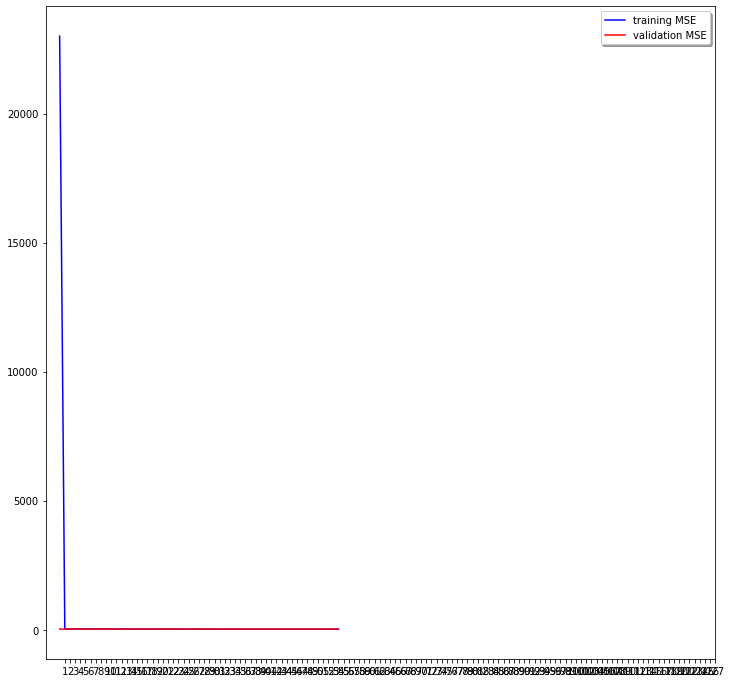

In [21]:
# Melakukan visualisasi nilai MSE pada data training dan testing.
fig, ax = plt.subplots(1, 1, figsize = (12, 12))
ax.plot(history.history['mse'], color='b', label = 'training MSE')
ax.plot(history.history['val_mse'], color='r', label = 'validation MSE')
ax.set_xticks(np.arange(1, epochs, 1))
legend = plt.legend(loc = 'best', shadow = True)
plt.show()

In [22]:
# Menyusun rekam jejak model berdasarkan nilai MSE pada setiap epoch, diurutkan dari yang terbaik.
history_df = pd.DataFrame(history.history).sort_values('val_mse').reset_index()
history_df.rename(columns = {'index': 'epoch'}, inplace = True)
history_df.to_csv('history_{}.csv'.format(codename), index = False)
history_df

,epoch,loss,mse,val_loss,val_mse,lr
0,14,27.353174,27.353170,25.485693,25.485682,0.049846
1,16,28.815987,28.815981,25.812254,25.812239,0.049846
2,17,27.995691,27.995678,26.173250,26.173239,0.049846
3,2,30.708574,30.708567,26.193041,26.193031,0.099691
4,20,30.173267,30.173254,26.210712,26.210697,0.049846
5,24,26.675478,26.675468,26.250793,26.250784,0.024923
6,19,29.513023,29.513014,26.361317,26.361303,0.049846
7,25,26.758577,26.758566,26.382872,26.382864,0.024923
8,7,30.365482,30.365471,26.425076,26.425060,0.099691
9,32,26.347160,26.347151,26.528269,26.528257,0.012461


In [23]:
# Menyimpan nilai prediksi validasi dan testing diurutkan berdasarkan nilai validasi MSE terbaik.
best_valid_preds = pd.DataFrame()
best_test_preds = pd.DataFrame()

for temp_index in list(history_df.iloc[:, 0]):
    temp_df_valid = pd.read_csv('./valid_preds_{}.csv'.format(temp_index))
    temp_df_test = pd.read_csv('./test_preds_{}.csv'.format(temp_index))
    best_valid_preds = pd.concat([best_valid_preds, temp_df_valid], axis = 1, ignore_index = True)
    best_test_preds = pd.concat([best_test_preds, temp_df_test], axis = 1, ignore_index = True)

best_valid_preds.to_csv('valid_preds_{}.csv'.format(codename), index = False)
best_test_preds.to_csv('test_preds_{}.csv'.format(codename), index = False)

In [24]:
# Membuang file yang sudah tidak diperlukan.
for temp_index in list(history_df.iloc[:, 0]):
    os.remove('./valid_preds_{}.csv'.format(temp_index))
    os.remove('./test_preds_{}.csv'.format(temp_index))

In [25]:
# Menampilkan prediksi data validasi diurutkan berdasarkan nilai validasi MSE terbaik.
best_valid_preds

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,25.914090,26.224445,27.405693,25.567408,26.993826,26.128948,27.510470,26.074177,25.602049,26.378817,...,27.803312,23.941364,24.663430,28.091198,28.419640,28.183455,27.768475,23.319538,22.801046,22.586636
1,23.825960,24.529740,24.705244,25.179968,23.816510,23.316992,25.374767,23.054180,24.557817,23.403234,...,25.064945,22.742514,21.941536,24.372372,26.475212,24.791300,26.711056,22.327919,21.687737,22.100754
2,27.370615,28.153381,28.570818,25.331295,28.998882,27.648457,28.523352,28.256567,26.254835,27.471817,...,29.686762,25.716593,25.845602,29.059717,30.017555,30.360968,28.763866,24.048367,22.729052,22.829643
3,25.983595,26.206347,26.956488,25.521376,26.363081,25.303488,27.054316,25.316042,25.853370,25.378628,...,27.501709,24.430544,23.743530,26.663172,28.610321,27.859224,28.335014,23.816416,22.804403,22.480957
4,25.256273,26.939350,27.035065,26.912119,26.223719,25.442380,27.119968,25.172360,26.565866,25.539171,...,27.337397,24.382437,23.576303,26.866861,28.226010,27.637201,28.558237,25.150928,23.845083,24.243640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,30.901848,30.367516,31.754793,26.135450,33.893044,32.627674,31.383173,35.426517,26.703445,35.469536,...,35.927700,27.934660,32.117344,39.317215,33.047990,37.443768,32.041046,24.566110,24.115667,23.803295
457,26.193483,27.341831,26.751741,25.304117,26.278002,25.898876,27.193804,26.107500,25.249560,26.128674,...,27.534924,24.425528,24.443796,27.472263,28.783531,28.899664,28.982250,23.492973,23.016035,22.795162
458,26.106016,26.454975,26.858831,25.130302,27.151220,26.228254,27.316486,26.428804,24.965588,26.614168,...,28.013514,23.553541,24.786404,28.462214,28.255877,28.303228,27.556770,23.255157,22.549623,21.970888
459,25.777193,27.015823,27.050226,25.222510,26.496172,25.756985,27.087568,25.441736,25.574793,25.789003,...,27.664337,23.723090,24.053904,27.954725,28.447460,27.737750,27.833150,23.179192,23.087910,22.424513


In [26]:
# Menampilkan prediksi data testing diurutkan berdasarkan nilai validasi MSE terbaik.
best_test_preds

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,25.655466,25.094954,26.294676,25.660166,25.286947,25.290878,25.696959,25.899706,26.148458,24.905860,...,27.310791,24.372976,23.727970,26.786797,27.937164,28.106250,28.752030,23.897400,23.083649,23.489280
1,26.799063,28.158709,28.032427,25.741758,27.425951,26.467800,28.040276,26.903505,25.601133,26.561888,...,28.575085,24.582426,24.830060,28.679468,29.457775,29.302202,28.656214,24.299118,23.395117,22.621962
2,26.437029,26.960693,27.436010,24.957075,27.357435,26.040224,27.355839,26.338425,24.966146,26.354620,...,28.168194,24.595540,24.580720,28.281054,28.919888,28.656630,28.396114,23.133633,22.493593,22.056501
3,27.722140,28.030193,28.152830,26.953142,28.597464,26.903835,28.302208,26.791600,26.644766,26.972440,...,29.115568,25.909838,25.269747,28.668242,30.075193,30.334085,29.645655,24.694778,24.130552,24.026222
4,25.416120,25.202541,25.587008,25.897331,24.561785,24.065779,25.537210,24.063831,26.262728,23.818476,...,26.494839,23.274488,22.056976,25.989260,27.580456,26.307467,28.200914,23.675207,23.013664,22.925660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,25.198900,26.447490,26.208221,26.093348,26.131233,25.436356,26.611506,25.719187,25.930050,25.751910,...,27.558163,23.994410,24.123108,27.751133,27.859330,27.193949,27.530090,23.821438,22.648390,22.849560
986,25.248188,25.094997,26.449550,25.245188,26.786474,25.393768,26.457030,25.747013,25.642569,25.640343,...,28.024069,24.315040,23.838232,27.766638,27.756413,28.144491,28.954212,22.170410,22.815233,22.824090
987,26.336412,26.559044,26.964308,25.415690,26.668457,25.494770,26.945866,26.422830,25.100840,26.025356,...,27.859547,24.644667,24.256080,26.882930,28.453999,28.243204,28.144222,23.429620,22.507576,22.320908
988,25.104937,24.598946,24.869108,25.646326,23.025540,23.366997,24.536583,22.100390,25.816545,22.022780,...,25.438710,22.755370,20.967380,23.112505,26.818111,25.433462,28.760075,23.434730,22.938782,23.125801


In [27]:
# Menampilkan nilai MSE terbaik pada data validasi.
error = MSE(y_valid, best_valid_preds[0])
print('nilai MSE pada data validasi: ', error)

nilai MSE pada data validasi:  25.485681617653942


In [28]:
# Mencatat waktu berakhirnya keseluruhan program model dan prediksi data.
global_end_time = time.time()

# Menampilkan waktu eksekusi dari keseluruhan program model dan prediksi data.
total_execution_time = datetime.timedelta(seconds = global_end_time - global_start_time)
print("total execution time: %s" % (total_execution_time))

total execution time: 0:11:16.682518
